In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-01 05:07:04.640936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 05:07:04.702506: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 05:07:05.116196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_113
rm: cannot remove '/kaggle/output/exp_113': No such file or directory


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:26<00:00,  1.04it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
926,21.070280,21.889490,4.451904,-20.794807,0.027129,0.014742,0.037067,477.5,0.0,68877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235,3
927,-2.156629,17.598087,3.993946,-21.465599,0.091583,0.079287,0.072814,597.5,0.0,68997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259,3
928,6.870979,16.874817,4.571238,-17.906569,0.048471,0.023354,0.085562,717.5,0.0,69117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22283,3
929,11.430203,8.910088,3.756421,-5.006313,0.029496,0.013204,0.031394,837.5,0.0,69237.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22307,3
930,10.291650,2.129946,1.981583,-21.022831,0.003008,0.001954,0.058677,957.5,0.0,69357.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22331,3


(494843, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:2.26589
[100]	eval-rmse:1.40762
[200]	eval-rmse:1.20935
[300]	eval-rmse:1.16242
[400]	eval-rmse:1.14806
[500]	eval-rmse:1.14296
[600]	eval-rmse:1.14058
[700]	eval-rmse:1.13884
[800]	eval-rmse:1.13769
[900]	eval-rmse:1.13701
[1000]	eval-rmse:1.13641
[1100]	eval-rmse:1.13606
[1200]	eval-rmse:1.13538
[1300]	eval-rmse:1.13494
[1400]	eval-rmse:1.13480
[1500]	eval-rmse:1.13465
[1600]	eval-rmse:1.13428
[1700]	eval-rmse:1.13414
[1800]	eval-rmse:1.13383
[1864]	eval-rmse:1.13387


 20%|██        | 1/5 [01:19<05:16, 79.03s/it]

== fold 1 ==
[0]	eval-rmse:2.39246
[100]	eval-rmse:1.49524
[200]	eval-rmse:1.28239
[300]	eval-rmse:1.23192
[400]	eval-rmse:1.21704
[500]	eval-rmse:1.21154
[600]	eval-rmse:1.20902
[700]	eval-rmse:1.20780
[800]	eval-rmse:1.20647
[900]	eval-rmse:1.20587
[1000]	eval-rmse:1.20542
[1100]	eval-rmse:1.20497
[1200]	eval-rmse:1.20488
[1300]	eval-rmse:1.20446
[1400]	eval-rmse:1.20412
[1500]	eval-rmse:1.20362
[1600]	eval-rmse:1.20358
[1700]	eval-rmse:1.20341
[1800]	eval-rmse:1.20317
[1900]	eval-rmse:1.20278
[2000]	eval-rmse:1.20236
[2100]	eval-rmse:1.20216
[2149]	eval-rmse:1.20224


 40%|████      | 2/5 [02:46<04:12, 84.11s/it]

== fold 2 ==
[0]	eval-rmse:2.34467
[100]	eval-rmse:1.50492
[200]	eval-rmse:1.30033
[300]	eval-rmse:1.25173
[400]	eval-rmse:1.23765
[500]	eval-rmse:1.23238
[600]	eval-rmse:1.23017
[700]	eval-rmse:1.22880
[800]	eval-rmse:1.22779
[900]	eval-rmse:1.22704
[1000]	eval-rmse:1.22670
[1100]	eval-rmse:1.22616
[1200]	eval-rmse:1.22601
[1300]	eval-rmse:1.22599
[1400]	eval-rmse:1.22562
[1500]	eval-rmse:1.22579
[1514]	eval-rmse:1.22587


 60%|██████    | 3/5 [03:50<02:29, 74.85s/it]

== fold 3 ==
[0]	eval-rmse:2.28641
[100]	eval-rmse:1.40414
[200]	eval-rmse:1.18844
[300]	eval-rmse:1.13768
[400]	eval-rmse:1.12346
[500]	eval-rmse:1.11914
[600]	eval-rmse:1.11666
[700]	eval-rmse:1.11527
[800]	eval-rmse:1.11448
[900]	eval-rmse:1.11361
[1000]	eval-rmse:1.11336
[1100]	eval-rmse:1.11296
[1200]	eval-rmse:1.11274
[1300]	eval-rmse:1.11273
[1400]	eval-rmse:1.11258
[1500]	eval-rmse:1.11252
[1600]	eval-rmse:1.11261
[1613]	eval-rmse:1.11254


 80%|████████  | 4/5 [04:56<01:11, 71.30s/it]

== fold 4 ==
[0]	eval-rmse:2.26721
[100]	eval-rmse:1.43197
[200]	eval-rmse:1.23487
[300]	eval-rmse:1.18890
[400]	eval-rmse:1.17606
[500]	eval-rmse:1.17017
[600]	eval-rmse:1.16768
[700]	eval-rmse:1.16619
[800]	eval-rmse:1.16546
[900]	eval-rmse:1.16514
[1000]	eval-rmse:1.16493
[1100]	eval-rmse:1.16494
[1118]	eval-rmse:1.16489


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:2.27003
[100]	eval-rmse:1.42913
[200]	eval-rmse:1.22360
[300]	eval-rmse:1.17362
[400]	eval-rmse:1.15661
[500]	eval-rmse:1.15057
[600]	eval-rmse:1.14630
[700]	eval-rmse:1.14418
[800]	eval-rmse:1.14329
[900]	eval-rmse:1.14227
[1000]	eval-rmse:1.14164
[1100]	eval-rmse:1.14102
[1200]	eval-rmse:1.14039
[1300]	eval-rmse:1.13985
[1400]	eval-rmse:1.13927
[1500]	eval-rmse:1.13873
[1600]	eval-rmse:1.13850
[1677]	eval-rmse:1.13853


 20%|██        | 1/5 [01:06<04:25, 66.43s/it]

== fold 1 ==
[0]	eval-rmse:2.38901
[100]	eval-rmse:1.49442
[200]	eval-rmse:1.27167
[300]	eval-rmse:1.21176
[400]	eval-rmse:1.19054
[500]	eval-rmse:1.18131
[600]	eval-rmse:1.17797
[700]	eval-rmse:1.17597
[800]	eval-rmse:1.17399
[900]	eval-rmse:1.17304
[1000]	eval-rmse:1.17228
[1100]	eval-rmse:1.17183
[1200]	eval-rmse:1.17152
[1300]	eval-rmse:1.17096
[1400]	eval-rmse:1.17038
[1500]	eval-rmse:1.16987
[1600]	eval-rmse:1.16956
[1700]	eval-rmse:1.16905
[1800]	eval-rmse:1.16880
[1900]	eval-rmse:1.16846
[2000]	eval-rmse:1.16811
[2100]	eval-rmse:1.16789
[2200]	eval-rmse:1.16795
[2270]	eval-rmse:1.16793


 40%|████      | 2/5 [02:35<03:59, 80.00s/it]

== fold 2 ==
[0]	eval-rmse:2.33201
[100]	eval-rmse:1.48435
[200]	eval-rmse:1.26581
[300]	eval-rmse:1.21260
[400]	eval-rmse:1.19391
[500]	eval-rmse:1.18808
[600]	eval-rmse:1.18533
[700]	eval-rmse:1.18356
[800]	eval-rmse:1.18207
[900]	eval-rmse:1.18078
[1000]	eval-rmse:1.17966
[1100]	eval-rmse:1.17921
[1200]	eval-rmse:1.17856
[1300]	eval-rmse:1.17827
[1400]	eval-rmse:1.17777
[1500]	eval-rmse:1.17754
[1600]	eval-rmse:1.17715
[1691]	eval-rmse:1.17716


 60%|██████    | 3/5 [03:43<02:29, 74.51s/it]

== fold 3 ==
[0]	eval-rmse:2.28031
[100]	eval-rmse:1.45530
[200]	eval-rmse:1.27543
[300]	eval-rmse:1.23666
[400]	eval-rmse:1.22417
[500]	eval-rmse:1.21834
[600]	eval-rmse:1.21612
[700]	eval-rmse:1.21493
[800]	eval-rmse:1.21400
[900]	eval-rmse:1.21348
[1000]	eval-rmse:1.21295
[1067]	eval-rmse:1.21304


 80%|████████  | 4/5 [04:30<01:03, 63.48s/it]

== fold 4 ==
[0]	eval-rmse:2.25906
[100]	eval-rmse:1.46414
[200]	eval-rmse:1.28971
[300]	eval-rmse:1.24761
[400]	eval-rmse:1.23311
[500]	eval-rmse:1.22660
[600]	eval-rmse:1.22323
[700]	eval-rmse:1.22136
[800]	eval-rmse:1.21994
[900]	eval-rmse:1.21880
[1000]	eval-rmse:1.21836
[1100]	eval-rmse:1.21757
[1200]	eval-rmse:1.21707
[1300]	eval-rmse:1.21689
[1400]	eval-rmse:1.21664
[1500]	eval-rmse:1.21614
[1600]	eval-rmse:1.21600
[1700]	eval-rmse:1.21580
[1795]	eval-rmse:1.21582


100%|██████████| 5/5 [05:40<00:00, 68.08s/it]


## Dynamic-Range NMS

<AxesSubplot: >

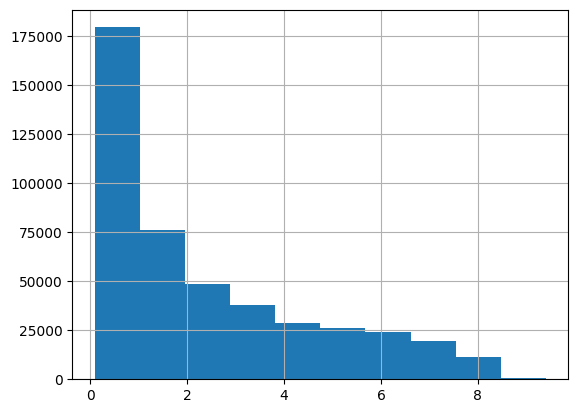

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:09<00:00, 28.03it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7626


event   tolerance
onset   12           0.179373
        36           0.588780
        60           0.744407
        90           0.813341
        120          0.841439
        150          0.861333
        180          0.874904
        240          0.892609
        300          0.899436
        360          0.906157
wakeup  12           0.168701
        36           0.606809
        60           0.750931
        90           0.811991
        120          0.841698
        150          0.863652
        180          0.879275
        240          0.897451
        300          0.909346
        360          0.919880
dtype: float64